In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd 
import cv2
import json
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as albu
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import tensorflow.keras.backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
import efficientnet.tfkeras as efn
print('tensorflow version:', tf.__version__)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

tensorflow version: 1.14.0
available GPU devices: 1 | device num: 0
1 Physical GPUs, 1 Logical GPUs


In [2]:
DATA_PATH = './data'
MODELS_PATH = './models'
IMG_SIZE = 300 #224=B0 240=B1 260=B2 300=B3 380=B4 456=B5
BATCH_SIZE = 8
MDL_VERSION = 'v3'
TIFF = -1
RESIZE = None
SEED = 80

In [3]:
train = pd.read_csv('{}/train.csv'.format(DATA_PATH))
print('train: ', train.shape, '| unique ids:', sum(train['isup_grade'].value_counts()))

train:  (10616, 4) | unique ids: 10616


In [4]:
def get_axis_max_min(array, axis=0):
    one_axis = list((array != 255).sum(axis=tuple([x for x in (0, 1, 2) if x != axis])))
    axis_min = next((i for i, x in enumerate(one_axis) if x), 0)
    axis_max = len(one_axis) - next((i for i, x in enumerate(one_axis[::-1]) if x), 0)
    return axis_min, axis_max

In [5]:
class DataGenPanda(Sequence):
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None,
                 tiff=-1, resize=None,
                 seq_len=12, img_size=128, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.tiff = tiff
        self.resize = resize
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float64)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['image_id'].values
        for i, img_name in enumerate(imgs_batch):
            img_path = '{}/{}.tiff'.format(self.imgs_path, img_name)
            X[i, ] = self.get_img(img_path)
        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            #y = np.zeros(self.batch_size, dtype=np.int16)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['isup_grade'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
                #y[i] = lbls_batch[i]
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
    def get_img(self, img_path):
        img = skimage.io.MultiImage(img_path)[self.tiff]
        if self.resize:
            img = cv2.resize(img, (int(img.shape[1] / self.resize), int(img.shape[0] / self.resize)))
        a0min, a0max = get_axis_max_min(img, axis=0)
        a1min, a1max = get_axis_max_min(img, axis=1)
        img = img[a0min:a0max, a1min:a1max, :].astype(np.float32) / 255
        if self.aug:
            img = self.aug(image=img)['image']
        return cv2.resize(img, (self.img_size, self.img_size))

In [6]:
X_train, X_val = train_test_split(train, test_size=.2, stratify=train['isup_grade'], random_state=SEED)
lbl_value_counts = X_train['isup_grade'].value_counts()
class_weights = {i: max(lbl_value_counts) / v for i, v in lbl_value_counts.items()}
class_weights

{0: 1.0,
 1: 1.0843881856540085,
 2: 2.153631284916201,
 4: 2.315315315315315,
 3: 2.3269617706237424,
 5: 2.362614913176711}

In [7]:
aug = albu.Compose(
    [
        albu.OneOf(
            [
                albu.RandomBrightness(limit=.15), 
                albu.RandomContrast(limit=.3), 
                albu.RandomGamma()
            ], 
            p=.25
        ),
        albu.HorizontalFlip(p=.25),
        albu.VerticalFlip(p=.25),
        albu.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=20, p=.25)
    ]
)
train_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_train, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=True, 
    aug=aug, 
    tiff=TIFF,
    resize=RESIZE,
    img_size=IMG_SIZE, 
    n_classes=6
)
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_val, 
    batch_size=BATCH_SIZE,
    mode='fit', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    img_size=IMG_SIZE, 
    n_classes=6
)

test X:  (8, 300, 300, 3)
test y:  (8, 6)


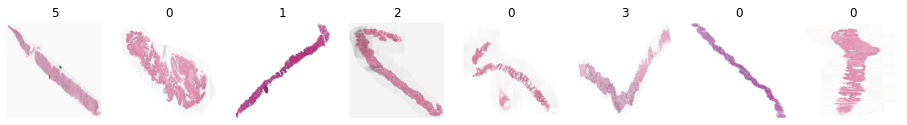

array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [8]:
Xt, yt = train_datagen.__getitem__(0)
print('test X: ', Xt.shape)
print('test y: ', yt.shape)
fig, axes = plt.subplots(figsize=(16, 6), ncols=BATCH_SIZE)
for j in range(BATCH_SIZE):
    axes[j].imshow(Xt[j])
    axes[j].axis('off')
    axes[j].set_title(np.argmax(yt[j, ]))
plt.show()
yt

In [9]:
bottleneck = efn.EfficientNetB3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet', include_top=False, pooling='avg'
)
bottleneck = Model(inputs=bottleneck.inputs, outputs=bottleneck.layers[-2].output)
model = Sequential()
model.add(bottleneck)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(256, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(6, activation='softmax'))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [11]:
def qw_kappa_score(y_true, y_pred): 
    y_true = tf.math.argmax(y_true, axis=1)
    y_pred = tf.math.argmax(y_pred, axis=1)
    def sklearn_qwk(y_true, y_pred) -> np.float64:
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return tf.compat.v1.py_func(sklearn_qwk, (y_true, y_pred), tf.double)

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-3),
    metrics=['categorical_accuracy', qw_kappa_score]
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [ ]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
if False:
    model = load_model(model_file)
    print('model loaded')
else:
    print('train from scratch')
EPOCHS = 100
earlystopper = EarlyStopping(
    monitor='val_qw_kappa_score', 
    patience=10, 
    verbose=1,
    mode='max'
)
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_qw_kappa_score', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)
lrreducer = ReduceLROnPlateau(
    monitor='val_qw_kappa_score',
    factor=.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)
history = model.fit_generator(
    train_datagen,
    validation_data=val_datagen,
    class_weight=class_weights,
    callbacks=[earlystopper, modelsaver, lrreducer],
    epochs=EPOCHS,
    verbose=1
)

train from scratch
Epoch 1/100
1060/1061 [============================>.] - ETA: 0s - loss: 3.3241 - categorical_accuracy: 0.2185 - qw_kappa_score: 0.1848
Epoch 00001: val_qw_kappa_score improved from -inf to 0.32436, saving model to ./models/model_v3.h5
1061/1061 [==============================] - 461s 434ms/step - loss: 3.3235 - categorical_accuracy: 0.2188 - qw_kappa_score: 0.1853 - val_loss: 1.6759 - val_categorical_accuracy: 0.2943 - val_qw_kappa_score: 0.3244
Epoch 2/100
1060/1061 [============================>.] - ETA: 0s - loss: 3.0358 - categorical_accuracy: 0.2474 - qw_kappa_score: 0.3027
Epoch 00002: val_qw_kappa_score did not improve from 0.32436
1061/1061 [==============================] - 449s 423ms/step - loss: 3.0358 - categorical_accuracy: 0.2472 - qw_kappa_score: 0.3028 - val_loss: 2.7222 - val_categorical_accuracy: 0.2321 - val_qw_kappa_score: 0.3005
Epoch 3/100
1060/1061 [============================>.] - ETA: 0s - loss: 2.9178 - categorical_accuracy: 0.2708 - qw_ka

In [ ]:
history_file = '{}/history_{}.txt'.format(MODELS_PATH, MDL_VERSION)
dict_to_save = {}
for k, v in history.history.items():
    dict_to_save.update({k: [np.format_float_positional(x) for x in history.history[k]]})
with open(history_file, 'w') as file:
    json.dump(dict_to_save, file)
ep_max = EPOCHS
plt.plot(history.history['loss'][:ep_max], label='loss')
plt.plot(history.history['val_loss'][:ep_max], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['categorical_accuracy'][:ep_max], label='cat acc')
plt.plot(history.history['val_categorical_accuracy'][:ep_max], label='val cat acc')
plt.legend()
plt.show()
plt.plot(history.history['qw_kappa_score'][:ep_max], label='qwk')
plt.plot(history.history['val_qw_kappa_score'][:ep_max], label='val qwk')
plt.legend()
plt.show()

In [10]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_PATH, MDL_VERSION)
model = load_model(model_file, custom_objects={'qw_kappa_score': qw_kappa_score})
print('model loaded:', model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
model loaded: ./models/model_v2.h5
CPU times: user 22.5 s, sys: 524 ms, total: 23 s
Wall time: 22.8 s


In [11]:
%%time
X_score = X_val.copy()
val_datagen = DataGenPanda(
    imgs_path='{}/train_images'.format(DATA_PATH), 
    df=X_score, 
    batch_size=1,
    mode='predict', 
    shuffle=False, 
    aug=None,
    tiff=TIFF,
    resize=RESIZE,
    seq_len=SEQ_LEN, 
    img_size=IMG_SIZE, 
    n_classes=6
)
preds = model.predict_generator(val_datagen)

CPU times: user 2min 19s, sys: 3.29 s, total: 2min 22s
Wall time: 1min 42s


In [12]:
y_true = X_score['isup_grade'].values
y_pred = np.argmax(preds, axis=1)
print('quadratic cappa score:', cohen_kappa_score(y_true, y_pred, weights='quadratic'))
print('confusion matrix:\n', confusion_matrix(y_true, y_pred))

quadratic cappa score: 0.7144073547511476
confusion matrix:
 [[479  65   5   3  17  10]
 [145 205 120  43  14   6]
 [ 26  59  95  68  17   4]
 [ 25  16  37  88  35  47]
 [ 25  16  17  55  56  81]
 [ 23   3   3  36  33 147]]
